In [105]:
import os
import math
import h5py
import numpy as np
import matplotlib as mpl
import grtrans_batch as gr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
os.environ["OMP_NUM_THREADS"] = "1"

In [106]:
header = np.loadtxt('grrmhd', max_rows=1)
mbhole = header[-2]
spin = header[-1]

In [107]:
kev = 2.41799050402417e17
ngrid = 200
a_spin = 0.9375 #spin
mbh = mbhole
xlim = 30

In [108]:
freq = 2*kev
ang = 80
amu = np.cos(ang*math.pi/180)

In [109]:
x = np.linspace(-xlim, xlim, ngrid)
X, Y = np.meshgrid(x, x, indexing="ij")

In [110]:
x = gr.grtrans()
x.write_grtrans_inputs('inputs.in',nfreq=1,nmu=1,mumin=amu,mumax=amu,fmin=freq,fmax=freq,fname="THINDISK",
                       ename="BBPOL",nvals=22,spin=a_spin,mbh=mbh,nn=[ngrid,ngrid,1],gridvals=[-xlim, xlim,-xlim, xlim])
x.run_grtrans()
x.read_grtrans_output()
vals = x.ivals[:,:,0]

THINDISK
grtrans.out
deleting grtrans.out...
 dfile: fieldline                                                                                                                                                                                                                                                 
 outfile grtrans: grtrans.out                                                                                                                                                                                                           �cf                                (   �-��                   CLICOLO                       1
 welcome to grtrans!
 fluid args: fieldline                                                                                           dump040                                                                                             dump0000rr2.bin                                                                                     thickdiskrr2                     

In [111]:
stokesi = (vals[:,0].reshape((ngrid,ngrid)))
stokesq = (vals[:,1].reshape((ngrid,ngrid)))
stokesu = (vals[:,2].reshape((ngrid,ngrid)))
i0 = (vals[:,4].reshape((ngrid,ngrid)))

In [112]:
# convert to cartesian coordinate #
def bl_to_cartesian(r, th, p, alpha, v_r, v_th, v_p):

  # the x,y,z position needs to be computed correctly #
  xa = np.sqrt(r**2 + alpha**2)
  sin_norm = xa * np.sin(th)
  x = sin_norm * np.cos(p)
  y = sin_norm * np.sin(p)
  z = r * np.cos(th)

  # the vectors, however, are locally flat #
  v_x = (v_r * np.sin(th) * np.cos(p)) + (np.cos(th) * np.cos(p) * v_th) - (np.sin(p) * v_p)
  v_y = (v_r * np.sin(th) * np.sin(p)) + (np.cos(th) * np.sin(p) * v_th) + (np.cos(p) * v_p)
  v_z = (v_r * np.cos(th)) - (np.sin(th) * v_th)

  return x, y, z, v_x, v_y, v_z

In [113]:
r = (vals[:,5].reshape((ngrid,ngrid)))
th = (vals[:,6].reshape((ngrid,ngrid)))
phi = (vals[:,7].reshape((ngrid,ngrid)))
br = (vals[:,8].reshape((ngrid,ngrid)))
bth = (vals[:,9].reshape((ngrid,ngrid)))
bphi = (vals[:,10].reshape((ngrid,ngrid)))
kr = (vals[:,11].reshape((ngrid,ngrid)))
kth = (vals[:,12].reshape((ngrid,ngrid)))
kphi = (vals[:,13].reshape((ngrid,ngrid)))
blr = (vals[:,17].reshape((ngrid,ngrid)))
blth = (vals[:,18].reshape((ngrid,ngrid)))
blphi = (vals[:,19].reshape((ngrid,ngrid)))
c2xi = (vals[:,20].reshape((ngrid,ngrid)))
s2xi = (vals[:,21].reshape((ngrid,ngrid)))

In [114]:
# copy from ipole #
itotal = stokesi + i0
evpa = (180/math.pi)*0.5*np.arctan2(stokesu,stokesq)
evpa += 90.
evpa[evpa > 90.] -= 180.
lp = np.sqrt(stokesq**2 + stokesu**2)/(itotal)

/tmp/ipykernel_72339/495713236.py:6: RuntimeWarning: invalid value encountered in divide
  lp = np.sqrt(stokesq**2 + stokesu**2)/(itotal)


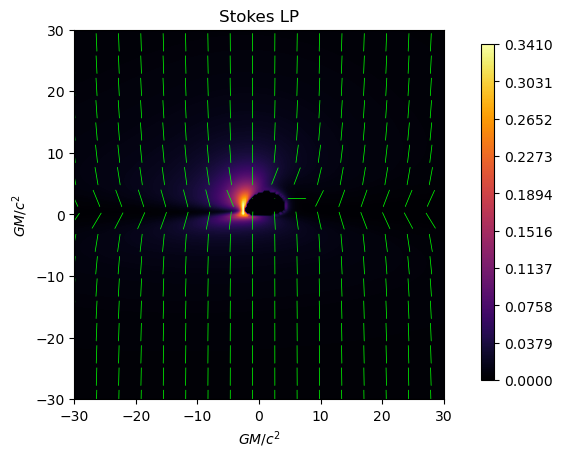

In [115]:
lp = np.nan_to_num(lp)
cmap = "inferno"
vmax = np.nanmax(lp)
vmin = np.nanmin(lp)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
tick = np.linspace(vmin, vmax, 10)
fig, ax = plt.subplots()
ax.contourf(X, Y, lp, 500, norm=norm, cmap=cmap)

lp = np.nan_to_num(lp)
scale = lp.copy()
scale[:,:] = 1
scale[lp == 0] = 0
vxp = scale*np.sin(evpa*math.pi/180) #lp/vmax*np.sin(evpa*math.pi/180)
vyp = - scale*np.cos(evpa*math.pi/180) #- lp/vmax*np.cos(evpa*math.pi/180)
skip = int(ngrid/16) 
ax.quiver(X[::skip,::skip], Y[::skip,::skip], vxp[::skip,::skip], vyp[::skip,::skip], 
           headwidth=1, headlength=1, width=0.002, color='#00ff00', units='width', scale=20, pivot='mid')

ax.set_title('Stokes LP')
ax.set_aspect('equal')
ax.set_xlabel(r"$GM/c^{2}$")
ax.set_ylabel(r"$GM/c^{2}$")
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=tick)

-7.414255004265934e-18


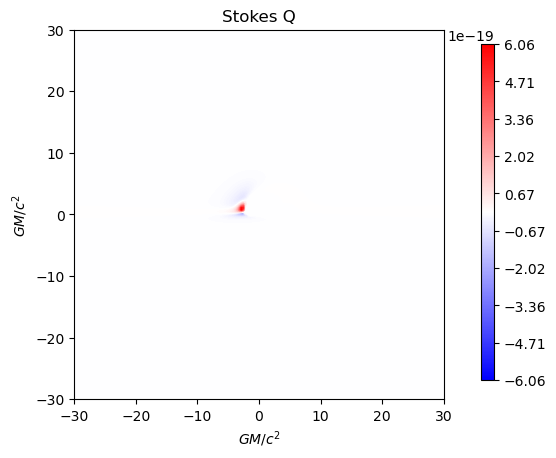

In [122]:
cmap = "bwr"
q0 = stokesq
maxval = np.nanmax(np.abs(q0))
vmin = -maxval
vmax = maxval
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
tick = np.linspace(vmin, vmax, 10)
fig, ax = plt.subplots()
ax.contourf(X, Y, q0, 500, norm=norm, cmap=cmap)
ax.set_title('Stokes Q')
ax.set_aspect('equal')
ax.set_xlabel(r"$GM/c^{2}$")
ax.set_ylabel(r"$GM/c^{2}$")
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=tick)

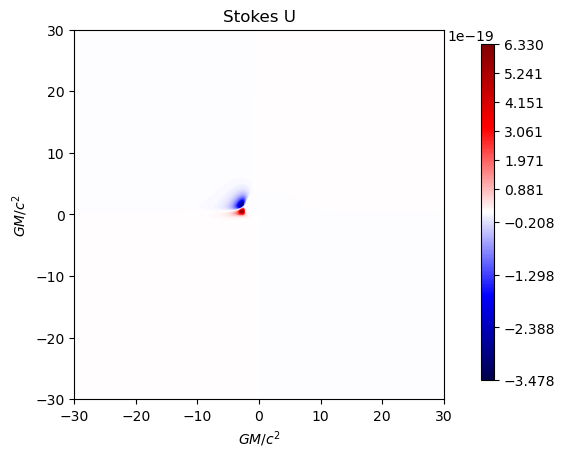

In [117]:
cmap = "seismic"
u0 = stokesu
vmax = np.nanmax(u0[u0 != np.inf])
vmin = np.nanmin(u0[u0 != -np.inf])
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
tick = np.linspace(vmin, vmax, 10)
fig, ax = plt.subplots()
ax.contourf(X, Y, u0, 500, norm=norm, cmap=cmap)
ax.set_title('Stokes U')
ax.set_aspect('equal')
ax.set_xlabel(r"$GM/c^{2}$")
ax.set_ylabel(r"$GM/c^{2}$")
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=tick)

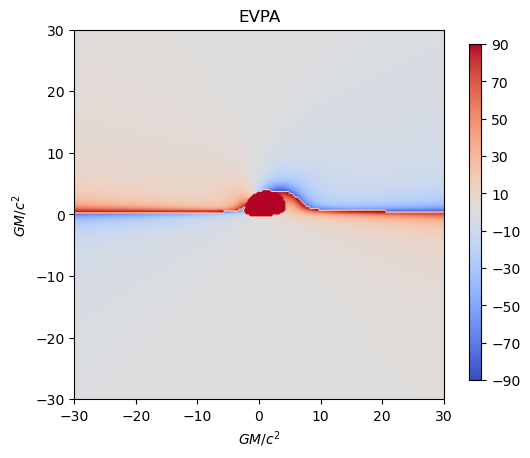

In [118]:
cmap = "coolwarm"
vmax = 90
vmin = -90
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
tick = np.linspace(vmin, vmax, 10)
fig, ax = plt.subplots()
ax.contourf(X, Y, evpa, 500, norm=norm, cmap=cmap)
ax.set_title('EVPA')
ax.set_aspect('equal')
ax.set_xlabel(r"$GM/c^{2}$")
ax.set_ylabel(r"$GM/c^{2}$")
cbar_ax = fig.add_axes([0.84, 0.15, 0.02, 0.7])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=tick)